In [20]:
import torch
import torch.nn as nn

from src.data.datasets import ModelParamsDataset
from src.model.models import SetTransformer

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from pathlib import Path

In [25]:
def get_accuracy(model: nn.Module, dataloader, emb=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct = 0
    model.eval()
    for X, y in dataloader:
        X = X.unsqueeze(2)
        if(emb is not None):
            emb_batch = emb.repeat(X.shape[0], 1, 1)
            X = torch.cat([emb_batch, X], dim=2)
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X.float())
        # Accuracy
        y = torch.argmax(y, dim=1)
        y_pred = torch.argmax(y_pred, dim=1)
        correct = (y_pred == y).sum()
        total_correct += correct

    accuracy_trained = total_correct / len(dataloader.dataset) * 100
    return accuracy_trained.item()

## Train

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 50
batch_size = 128
random_seed = 42
dataset_splits = [0.7, 0.2, 0.1]

torch.manual_seed(random_seed)
# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv", get_as_classes=True)
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, dataset_splits)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = SetTransformer(3, 8, 1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Locations
path = "../../models/classifiers/set_transformers/"
model_path = "{}/set_transformers_small.pth".format(path)

In [9]:
# Embeddings

# Small
pos_emb = torch.tensor([0] * 24 + [1] * 9 )
type_emb = torch.tensor([0] * 16 + [1] * 8 + [0] * 8 + [1] * 1 )

# # Big
# pos_emb = torch.tensor([0] * 30 + [1] * 110 + [2] * 110 + [3] * 11)
# type_emb = torch.tensor([0] * 20 + [1] * 10 + [0] * 100 + [1] * 10 + [0] * 100 + [1] * 10 + [0] * 10 + [1] * 1)

emb = torch.stack([pos_emb, type_emb], dim=1)
# emb = emb.repeat(batch_size, 1, 1)

In [10]:
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters, angle) in train_dataloader:
        # Add embeddings
        parameters = parameters.unsqueeze(2)
        emb_batch = emb.repeat(batch_size, 1, 1)
        parameters = torch.cat([emb_batch, parameters], dim=2)

        parameters = parameters.to(device)
        angle = angle.to(device)

        output = model(parameters)
        loss = criterion(output, angle)
        
        optimizer.zero_grad()
        loss.backward()
        # clip_grad(model, 5)
        optimizer.step()    

        total_loss += loss.item()
    
    print("Epoch: {}, Loss: {}".format(epoch, total_loss))
    losses.append(total_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, Loss: 1141.6466081142426
Epoch: 1, Loss: 1178.0883074998856
Epoch: 2, Loss: 1203.6672806739807
Epoch: 3, Loss: 1203.014886379242
Epoch: 4, Loss: 1203.0148854255676
Epoch: 5, Loss: 1203.0148882865906
Epoch: 6, Loss: 1203.0148878097534
Epoch: 7, Loss: 1203.0148861408234
Epoch: 8, Loss: 1203.0148890018463
Epoch: 9, Loss: 1203.0148878097534
Epoch: 10, Loss: 1203.0148832798004
Epoch: 11, Loss: 1203.0148866176605
Epoch: 12, Loss: 1203.014886379242
Epoch: 13, Loss: 1203.014885187149
Epoch: 14, Loss: 1203.0148856639862
Epoch: 15, Loss: 1203.014883518219
Epoch: 16, Loss: 1203.014886379242
Epoch: 17, Loss: 1203.0148875713348
Epoch: 18, Loss: 1203.0148820877075
Epoch: 19, Loss: 1203.014885187149
Epoch: 20, Loss: 1203.0148854255676
Epoch: 21, Loss: 1203.014888048172
Epoch: 22, Loss: 1203.014886856079
Epoch: 23, Loss: 1203.0148887634277
Epoch: 24, Loss: 1203.0148859024048
Epoch: 25, Loss: 1203.0148875713348
Epoch: 26, Loss: 1203.0148859024048
Epoch: 27, Loss: 1203.0148885250092
Epoch: 28,

In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

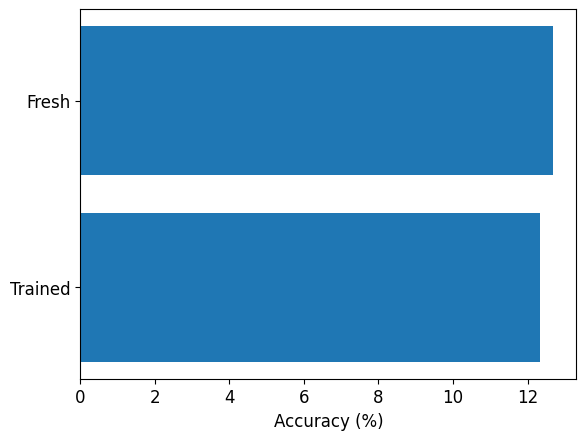

In [19]:
model_fresh = SetTransformer(3, 8, 1)
accuracy_fresh = get_accuracy(model_fresh, test_dataloader)
accuracy_trained = get_accuracy(model, test_dataloader)

plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.savefig("../../reports/set-transformer-small-accuracy.pdf")
plt.show()

## Train set size experiments

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pos_emb = torch.tensor([0] * 30 + [1] * 110 + [2] * 110 + [3] * 11)
type_emb = torch.tensor([0] * 20 + [1] * 10 + [0] * 100 + [1] * 10 + [0] * 100 + [1] * 10 + [0] * 10 + [1] * 1)
emb = torch.stack([pos_emb, type_emb], dim=1)

epochs = 50
batch_size = 128
random_seed = 42

models_dir = Path("../../models/classifiers/set_transformers/")

dataset = ModelParamsDataset("../../data/zoo_big.csv", get_as_classes=True)

Train sample: 80
Validation sample: 80
Test sample: 79840


  0%|          | 0/50 [00:00<?, ?it/s]

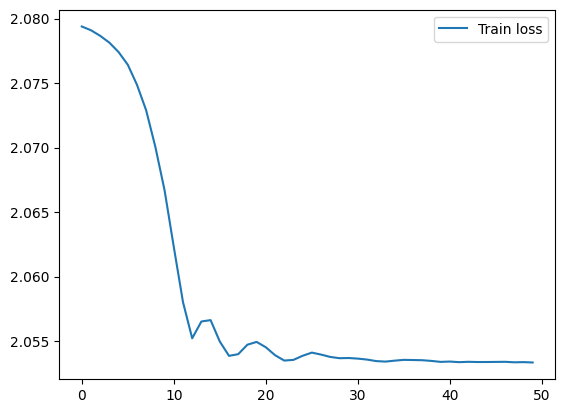

Accuracy: 12.494989395141602
Train sample: 800
Validation sample: 800
Test sample: 78400


  0%|          | 0/50 [00:00<?, ?it/s]

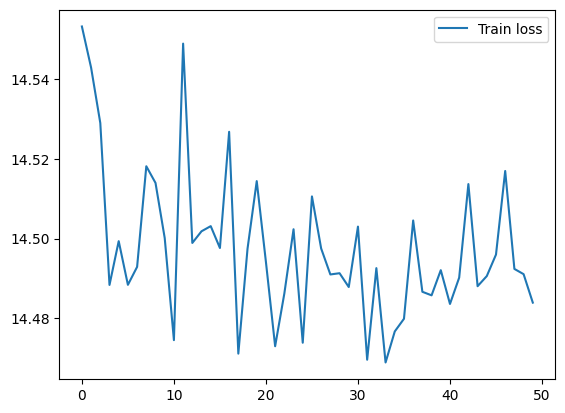

Accuracy: 12.44515323638916
Train sample: 1600
Validation sample: 1600
Test sample: 76800


  0%|          | 0/50 [00:00<?, ?it/s]

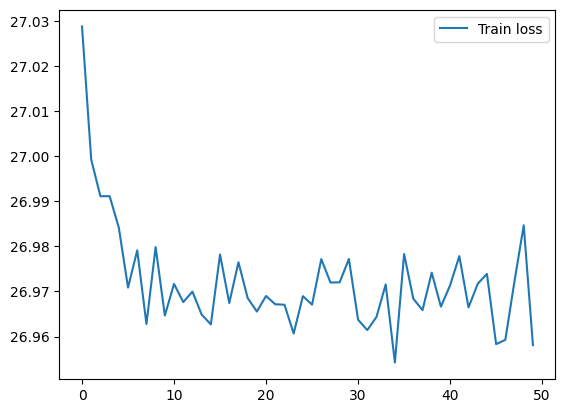

Accuracy: 12.444010734558105
Train sample: 4000
Validation sample: 4000
Test sample: 72000


  0%|          | 0/50 [00:00<?, ?it/s]

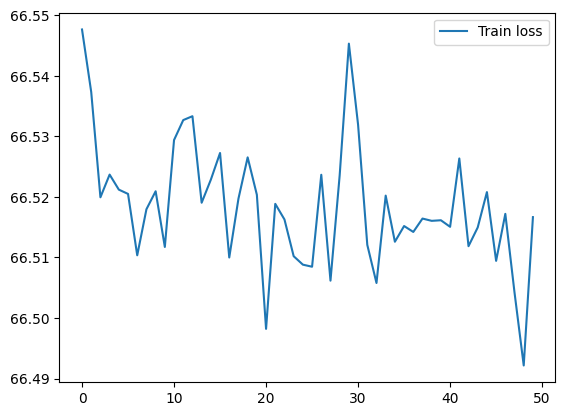

Accuracy: 12.477777481079102
Train sample: 8000
Validation sample: 8000
Test sample: 64000


  0%|          | 0/50 [00:00<?, ?it/s]

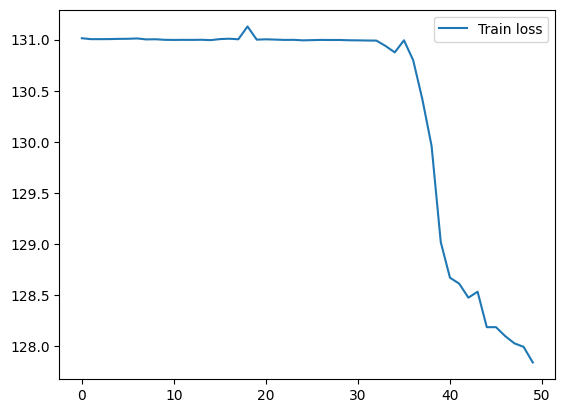

Accuracy: 19.564064025878906
Train sample: 16000
Validation sample: 16000
Test sample: 48000


  0%|          | 0/50 [00:00<?, ?it/s]

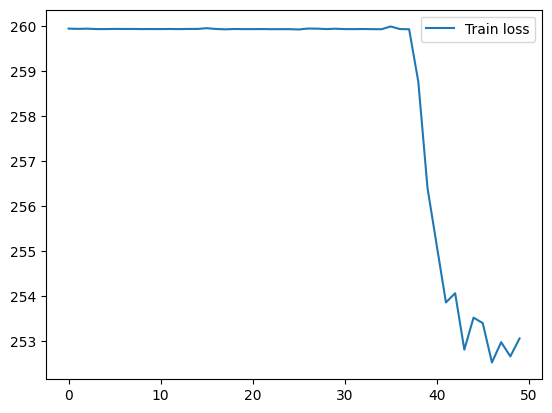

Accuracy: 17.835416793823242
Train sample: 40000
Validation sample: 24000
Test sample: 16000


  0%|          | 0/50 [00:00<?, ?it/s]

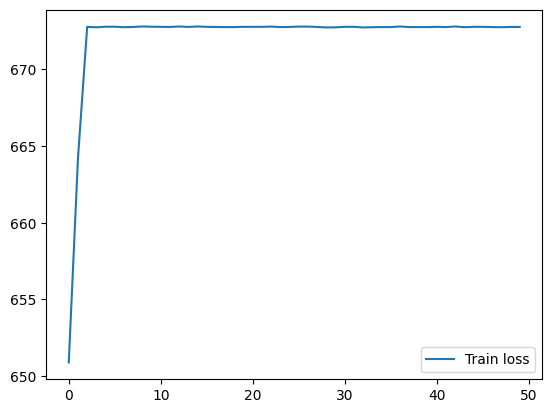

Accuracy: 12.481250762939453
Train sample: 56000
Validation sample: 16000
Test sample: 8000


  0%|          | 0/50 [00:00<?, ?it/s]

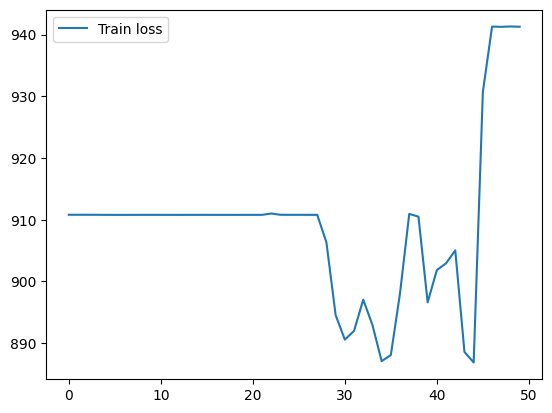

Accuracy: 12.262500762939453
Train sample: 64000
Validation sample: 8000
Test sample: 8000


  0%|          | 0/50 [00:00<?, ?it/s]

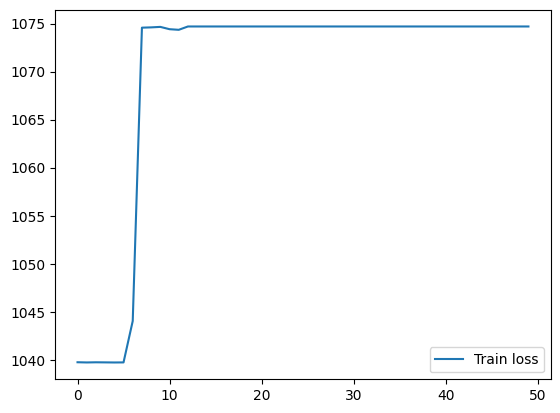

Accuracy: 12.450000762939453
Train sample: 72000
Validation sample: 4000
Test sample: 4000


  0%|          | 0/50 [00:00<?, ?it/s]

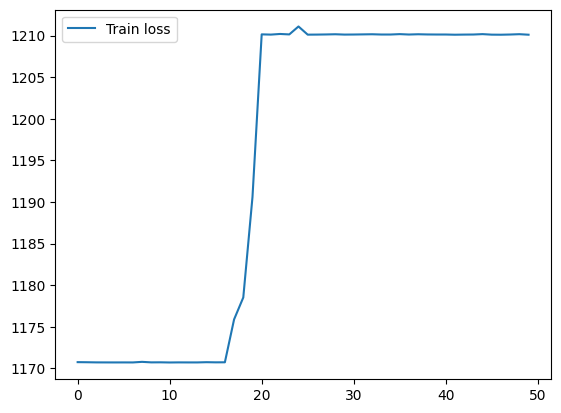

Accuracy: 12.525001525878906


In [27]:
for dataset_splits in [[0.001, 0.001, 0.998], [0.01, 0.01, 0.98], [0.02, 0.02, 0.96], [0.05, 0.05, 0.9], [0.1, 0.1, 0.8], [0.2, 0.2, 0.6], [0.5, 0.3, 0.2], [0.7, 0.2, 0.1], [0.8, 0.1, 0.1], [0.9, 0.05, 0.05]]:
    torch.manual_seed(random_seed)

    # Split into train, validation and test sets
    dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    print("Train sample:", len(dataset_train))
    print("Validation sample:", len(dataset_valid))
    print("Test sample:", len(dataset_test))

    torch.manual_seed(random_seed)

    # Init
    model = SetTransformer(3, 8, 1)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = dict()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for (parameters, angle) in dataloader_train:
            # Add embeddings
            parameters = parameters.unsqueeze(2)
            emb_batch = emb.repeat(parameters.shape[0], 1, 1)
            parameters = torch.cat([emb_batch, parameters], dim=2)

            parameters = parameters.to(device)
            angle = angle.to(device)

            output = model(parameters)
            loss = criterion(output, angle)
            
            optimizer.zero_grad()
            loss.backward()
            # clip_grad(model, 5)
            optimizer.step()    

            total_loss += loss.item()
        
        losses.append(total_loss)

    plt.plot(losses, label="Train loss")
    plt.legend()
    plt.show()

    torch.save(model.state_dict(), models_dir / f"set-transformer_{dataset_splits[0]}.pth")
    accuracy = get_accuracy(model, dataloader_test, emb)
    accuracies[dataset_splits[0]] = accuracy
    print("Accuracy:", accuracy)